In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/Users/Bellevue/DSC530/miniconda3/envs/book_env/kaggle.json'
import pandas as pd 
import numpy as np 
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from thefuzz import process, fuzz

# Prison Admissions Data Analysis

## Project Milestone 2

In [2]:
#load flat file dataset
prison_df = pd.read_csv('admissions_releases_states.csv')
prison_df.head()

,date,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state
0,2015-02-01,1583,600,193,633.0,130.0,6.0,21.0,1649,653,194,688.0,85.0,7.0,22.0,Arizona
1,2015-03-01,1580,615,189,640.0,114.0,3.0,19.0,1559,644,169,610.0,111.0,6.0,19.0,Arizona
2,2015-04-01,1779,706,235,701.0,115.0,4.0,18.0,1693,703,206,657.0,93.0,5.0,29.0,Arizona
3,2015-05-01,1821,730,260,669.0,125.0,8.0,29.0,1659,685,193,616.0,136.0,3.0,26.0,Arizona
4,2015-06-01,1689,704,215,618.0,129.0,0.0,23.0,1570,651,174,603.0,111.0,7.0,24.0,Arizona


In [3]:
#show the number of NaN's 
prison_df.isna().sum()

date                   0
admissions_total       0
admissions_white       0
admissions_black       0
admissions_hispanic    0
admissions_amerind     0
admissions_asian       0
admissions_other       0
releases_total         0
releases_white         0
releases_black         0
releases_hispanic      0
releases_amerind       0
releases_asian         0
releases_other         0
state                  0
dtype: int64

In [4]:
# # data cleaning step #1 count the number of records by state to determine outliers
prison_df_outliers = prison_df.groupby('state').count()[['date']].rename(columns={'date':'count'})
prison_df_outliers
# data isnt evenly distributed as Wisconsin has way more entries than other states

,count
state,
Arizona,92
California,43
Colorado,152
Idaho,92
Illinois,66
Iowa,122
Kansas,93
Kentucky,175
Maine,93


In [5]:
# data cleaning step #2 convert date column to datetime format for timeseries analysis
prison_df['date'] = pd.to_datetime(prison_df['date'])

In [6]:
# data cleaning step #3 set the date as the index 
prison_df.set_index('date', inplace=True)
prison_df.head() 

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state
date,,,,,,,,,,,,,,,
2015-02-01,1583,600,193,633.0,130.0,6.0,21.0,1649,653,194,688.0,85.0,7.0,22.0,Arizona
2015-03-01,1580,615,189,640.0,114.0,3.0,19.0,1559,644,169,610.0,111.0,6.0,19.0,Arizona
2015-04-01,1779,706,235,701.0,115.0,4.0,18.0,1693,703,206,657.0,93.0,5.0,29.0,Arizona
2015-05-01,1821,730,260,669.0,125.0,8.0,29.0,1659,685,193,616.0,136.0,3.0,26.0,Arizona
2015-06-01,1689,704,215,618.0,129.0,0.0,23.0,1570,651,174,603.0,111.0,7.0,24.0,Arizona


In [8]:
# data cleaning step #4 look for duplicates and remove if applicable
duplicates = prison_df[prison_df.duplicated()]
# duplicates
# remove duplicate rows from the dataframe
prison_df = prison_df.drop_duplicates()
prison_df.head()

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state
date,,,,,,,,,,,,,,,
2015-02-01,1583,600,193,633.0,130.0,6.0,21.0,1649,653,194,688.0,85.0,7.0,22.0,Arizona
2015-03-01,1580,615,189,640.0,114.0,3.0,19.0,1559,644,169,610.0,111.0,6.0,19.0,Arizona
2015-04-01,1779,706,235,701.0,115.0,4.0,18.0,1693,703,206,657.0,93.0,5.0,29.0,Arizona
2015-05-01,1821,730,260,669.0,125.0,8.0,29.0,1659,685,193,616.0,136.0,3.0,26.0,Arizona
2015-06-01,1689,704,215,618.0,129.0,0.0,23.0,1570,651,174,603.0,111.0,7.0,24.0,Arizona


In [11]:
# data cleaning step #5 rename the state Kentucky, Georgia
prison_df.loc[prison_df['state'] == 'Kentucky', 'state'] = 'Georgia'
# verify the state name change 
prison_df[prison_df['state'] == 'Georgia']

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state,net_flow
date,,,,,,,,,,,,,,,,
2008-01-01,1530,1100,396,18.0,1.0,4.0,11.0,955,684,256,4.0,2.0,3.0,6.0,Georgia,575
2008-02-01,1430,1024,382,16.0,0.0,0.0,8.0,1507,1091,389,17.0,0.0,3.0,7.0,Georgia,-77
2008-03-01,1328,966,323,23.0,1.0,3.0,12.0,1021,766,243,6.0,1.0,0.0,5.0,Georgia,307
2008-04-01,1385,992,366,12.0,0.0,1.0,14.0,1336,979,333,14.0,1.0,2.0,7.0,Georgia,49
2008-05-01,1410,994,388,15.0,2.0,3.0,8.0,1817,1320,463,26.0,2.0,0.0,6.0,Georgia,-407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,1413,1147,226,14.0,3.0,4.0,19.0,1216,1011,183,10.0,2.0,1.0,9.0,Georgia,197
2022-04-01,1295,1066,196,14.0,0.0,2.0,17.0,1402,1159,215,10.0,1.0,4.0,13.0,Georgia,-107
2022-05-01,1348,1108,205,17.0,1.0,0.0,17.0,882,720,140,8.0,2.0,1.0,11.0,Georgia,466


In [10]:
# data cleaning step #6 add a column to calculate prison population growth (admissions - releases)
prison_df.loc[:, 'net_flow'] = prison_df['admissions_total'] - prison_df['releases_total']
prison_df.head()

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state,net_flow
date,,,,,,,,,,,,,,,,
2015-02-01,1583,600,193,633.0,130.0,6.0,21.0,1649,653,194,688.0,85.0,7.0,22.0,Arizona,-66
2015-03-01,1580,615,189,640.0,114.0,3.0,19.0,1559,644,169,610.0,111.0,6.0,19.0,Arizona,21
2015-04-01,1779,706,235,701.0,115.0,4.0,18.0,1693,703,206,657.0,93.0,5.0,29.0,Arizona,86
2015-05-01,1821,730,260,669.0,125.0,8.0,29.0,1659,685,193,616.0,136.0,3.0,26.0,Arizona,162
2015-06-01,1689,704,215,618.0,129.0,0.0,23.0,1570,651,174,603.0,111.0,7.0,24.0,Arizona,119


In [13]:
# data cleaning step #7 calculate the monthly change in admissions
prison_df = prison_df.copy()
prison_df['admissions_total_change'] = prison_df['admissions_total'].diff()
prison_df.head()

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,state,net_flow,admissions_total_change
date,,,,,,,,,,,,,,,,,
2015-02-01,1583,600,193,633.0,130.0,6.0,21.0,1649,653,194,688.0,85.0,7.0,22.0,Arizona,-66,NaN
2015-03-01,1580,615,189,640.0,114.0,3.0,19.0,1559,644,169,610.0,111.0,6.0,19.0,Arizona,21,-3.0
2015-04-01,1779,706,235,701.0,115.0,4.0,18.0,1693,703,206,657.0,93.0,5.0,29.0,Arizona,86,199.0
2015-05-01,1821,730,260,669.0,125.0,8.0,29.0,1659,685,193,616.0,136.0,3.0,26.0,Arizona,162,42.0
2015-06-01,1689,704,215,618.0,129.0,0.0,23.0,1570,651,174,603.0,111.0,7.0,24.0,Arizona,119,-132.0


In [12]:
# calculate the descriptive statistics for every numeric column 
central_tendency_df = prison_df.describe().loc[['mean', '50%']].rename(index={'mean':'mean', '50%':'median'})
central_tendency_df

,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,net_flow,admissions_total_change
mean,820.573422,458.653519,163.87318,164.676578,17.797937,3.589806,11.119539,879.401699,478.591626,182.949636,182.723301,18.109223,3.720267,13.518811,-58.828277,0.369763
median,516.000000,342.500000,89.50000,33.000000,10.000000,2.000000,2.000000,551.000000,361.000000,102.000000,35.000000,10.000000,2.000000,2.000000,-12.000000,-1.000000


In [14]:
# data cleaning step #8 create a subset of the dataset to group admissions by race and state
state_totals = prison_df.groupby('state')[['admissions_white', 'admissions_black', 
     'admissions_hispanic', 'admissions_amerind', 
     'admissions_asian', 'admissions_other']
].sum() 
print(state_totals)

               admissions_white  admissions_black  admissions_hispanic  \
state                                                                    
Arizona                   49413             16605              47482.0   
California                24110             20494              43924.0   
Colorado                  53604             18333              35262.0   
Georgia                  203958             45243               2390.0   
Idaho                     36525              1387               6374.0   
Illinois                   8550             12337               2360.0   
Iowa                      32430             10693               2824.0   
Kansas                    36374             11923                  0.0   
Maine                      6833               861                  0.0   
Massachusetts             49685             14215              10945.0   
Montana                    6323               290                  0.0   
Nebraska                  12538       

In [15]:
print(prison_df)

            admissions_total  admissions_white  admissions_black  \
date                                                               
2015-02-01              1583               600               193   
2015-03-01              1580               615               189   
2015-04-01              1779               706               235   
2015-05-01              1821               730               260   
2015-06-01              1689               704               215   
...                      ...               ...               ...   
2022-03-01              3475               812               746   
2022-04-01              3126               770               701   
2022-05-01              3221               851               699   
2022-06-01              2624               611               576   
2022-07-01              2192               604               479   

            admissions_hispanic  admissions_amerind  admissions_asian  \
date                                      

In [16]:
# group by state and sum all numeric columns for SQL database table 
summary_by_state = prison_df.groupby('state').sum()
# move state back as a column instead of the index
summary_by_state = summary_by_state.reset_index()
# striip any spaces and make it lower case.
summary_by_state['state'] = summary_by_state['state'].str.strip().str.lower()
# show the first 5 rows
summary_by_state.head()

,state,admissions_total,admissions_white,admissions_black,admissions_hispanic,admissions_amerind,admissions_asian,admissions_other,releases_total,releases_white,releases_black,releases_hispanic,releases_amerind,releases_asian,releases_other,net_flow,admissions_total_change
0,arizona,126061,49413,16605,47482.0,9673.0,524.0,2366.0,134810,52990,17152,51527.0,10166.0,539.0,2439.0,-8749,-308.0
1,california,92841,24110,20494,43924.0,0.0,0.0,4965.0,123602,30818,29375,56206.0,0.0,0.0,8923.0,-30761,1668.0
2,colorado,112963,53604,18333,35262.0,4640.0,919.0,116.0,119043,55805,19838,37482.0,4787.0,978.0,153.0,-6080,-52.0
3,georgia,254678,203958,45243,2390.0,226.0,288.0,2573.0,253245,201078,46978,2287.0,229.0,292.0,2381.0,1433,1047.0
4,idaho,48186,36525,1387,6374.0,1869.0,0.0,1512.0,47645,36525,1387,6374.0,1869.0,0.0,1512.0,541,-972.0


## Project Milestone 3

In [17]:
# web scraping Wiki page 
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_incarceration_and_correctional_supervision_rate'

In [18]:
page = requests.get(url)

In [19]:
# Read all tables from the page
tables = pd.read_html(url)
print(f"Found {len(tables)} tables.")
# tables

Found 8 tables.


In [20]:
# list the table index 
for index, table in enumerate(tables):
    print(f"\n--- Table {index} ---")
    print(table.head())


--- Table 0 ---
         Location  Incarceration rate  Total incarcerated  State population  \
0       Alabama *                 898               45573           5073903   
1        Alaska *                 744                5456            733276   
2  American Samoa                 606                 301             49710   
3       Arizona *                 710               52329           7365684   
4      Arkansas *                 912               27795           3046404   

   State prisons  Federal  Local jails  
0        26421.0   3607.0      14727.0  
1         4778.0    498.0         12.0  
2          301.0      NaN          NaN  
3        33865.0   3567.0      13541.0  
4        17625.0   2522.0       7165.0  

--- Table 1 ---
         Location  Youth  Indian Country jails  Civil commitment  \
0       Alabama *  678.0                   NaN               NaN   
1        Alaska *  156.0                   2.0               NaN   
2  American Samoa    NaN                 

In [21]:
# create a dataframe with one of the tables
incarceration_table = tables[0]
# show the first 5 rows
incarceration_table.head()

,Location,Incarceration rate,Total incarcerated,State population,State prisons,Federal,Local jails
0,Alabama *,898,45573,5073903,26421.0,3607.0,14727.0
1,Alaska *,744,5456,733276,4778.0,498.0,12.0
2,American Samoa,606,301,49710,301.0,NaN,NaN
3,Arizona *,710,52329,7365684,33865.0,3567.0,13541.0
4,Arkansas *,912,27795,3046404,17625.0,2522.0,7165.0


In [22]:
# data cleaning step # 1 remove whitespace/characters from location data
incarceration_table['Location']= incarceration_table['Location'].str.strip()
# strip specific charater from location
char_to_strip = '*'
# remove * from location 
incarceration_table['Location'] = incarceration_table['Location'].str.strip(char_to_strip)
# view results - first 5 rows
incarceration_table.head()

,Location,Incarceration rate,Total incarcerated,State population,State prisons,Federal,Local jails
0,Alabama,898,45573,5073903,26421.0,3607.0,14727.0
1,Alaska,744,5456,733276,4778.0,498.0,12.0
2,American Samoa,606,301,49710,301.0,NaN,NaN
3,Arizona,710,52329,7365684,33865.0,3567.0,13541.0
4,Arkansas,912,27795,3046404,17625.0,2522.0,7165.0


In [23]:
# bring in the male and female incarceration and correctional supervision table
mf_incarceration_table = tables[5]
# view results - first 5 rows
mf_incarceration_table.head()

Jurisdiction Parole, probation, etc.                                 \
  Jurisdiction                  Number                    Rate          
  Jurisdiction                   Total     Male   Female  Male Female   
0        State                 4518100  3485100  1033000  2190    630   
1      Federal                  132800   109200    23700    70     10   
2   U.S. total                 4650900  3594300  1056700  2260    640   
3    Alabama *                   64600    50600    14000  2140    560   
4     Alaska *                    8500     6600     1900  1700    550   

  Incarcerated                                
        Number                   Rate         
         Total     Male  Female  Male Female  
0      1949400  1759700  189800  1450    150  
1       195700   182800   12900   150     10  
2      2145100  1942500  202600  1600    160  
3        42900    38600    4300  1640    170  
4         5400     4800     600  1230    170

In [24]:
# data cleaning step # 2 replace headers
# define the new header names
new_headers = [
    'Jurisdiction',
    'Parole_Total', 'Parole_Male', 'Parole_Female', 'Parole_Rate_Male', 'Parole_Rate_Female',
    'Incarcerated_Total', 'Incarcerated_Male', 'Incarcerated_Female', 'Incarcerated_Rate_Male', 'Incarcerated_Rate_Female'
]

In [25]:
# set the new header names 
mf_incarceration_table.columns= new_headers
# view results with new headers 
mf_incarceration_table.head()

,Jurisdiction,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female
0,State,4518100,3485100,1033000,2190,630,1949400,1759700,189800,1450,150
1,Federal,132800,109200,23700,70,10,195700,182800,12900,150,10
2,U.S. total,4650900,3594300,1056700,2260,640,2145100,1942500,202600,1600,160
3,Alabama *,64600,50600,14000,2140,560,42900,38600,4300,1640,170
4,Alaska *,8500,6600,1900,1700,550,5400,4800,600,1230,170


In [26]:
# data cleaning step # 3 remove whitespace/characters from male/female location data using strip/replaceall
mf_incarceration_table['Jurisdiction']= mf_incarceration_table['Jurisdiction'].str.strip()

In [27]:
# remove * from Jurisdiction
mf_incarceration_table['Jurisdiction'] = mf_incarceration_table['Jurisdiction'].str.replace('*','',regex=False)
# view results - first 10 rows
mf_incarceration_table.head(10)

,Jurisdiction,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female
0,State,4518100,3485100,1033000,2190,630,1949400,1759700,189800,1450,150
1,Federal,132800,109200,23700,70,10,195700,182800,12900,150,10
2,U.S. total,4650900,3594300,1056700,2260,640,2145100,1942500,202600,1600,160
3,Alabama,64600,50600,14000,2140,560,42900,38600,4300,1640,170
4,Alaska,8500,6600,1900,1700,550,5400,4800,600,1230,170
5,Arizona,83300,66700,16700,1950,480,54900,49100,5800,1440,170
6,Arkansas,51500,39000,12500,2660,820,24000,21200,2800,1450,180
7,California,349600,277500,72100,1420,360,201000,186000,15100,950,80
8,Colorado,89200,66700,22400,2410,820,31800,28000,3800,1010,140
9,Connecticut,45300,35700,9500,2040,520,15800,14700,1100,840,60


In [28]:
# data cleaning step # 4 create a function to perform fuzzy matching using thefuzz
def fix_dc (name):
    match = process.extractOne(name, ['District of Columbia'], scorer=fuzz.ratio)
    #*****note to self look into vectorization
    if match and match[1] >= 80:  # if match score ≥ 80 
        return 'Washington, D.C.'
    else:
        return name 

In [29]:
# apply the fuzzy matching function to the mf_incarceration_table
mf_incarceration_table['New_Location'] =  mf_incarceration_table['Jurisdiction'].apply(fix_dc)
# view results - first 12 rows
mf_incarceration_table.head(12)

,Jurisdiction,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female,New_Location
0,State,4518100,3485100,1033000,2190,630,1949400,1759700,189800,1450,150,State
1,Federal,132800,109200,23700,70,10,195700,182800,12900,150,10,Federal
2,U.S. total,4650900,3594300,1056700,2260,640,2145100,1942500,202600,1600,160,U.S. total
3,Alabama,64600,50600,14000,2140,560,42900,38600,4300,1640,170,Alabama
4,Alaska,8500,6600,1900,1700,550,5400,4800,600,1230,170,Alaska
5,Arizona,83300,66700,16700,1950,480,54900,49100,5800,1440,170,Arizona
6,Arkansas,51500,39000,12500,2660,820,24000,21200,2800,1450,180,Arkansas
7,California,349600,277500,72100,1420,360,201000,186000,15100,950,80,California
8,Colorado,89200,66700,22400,2410,820,31800,28000,3800,1010,140,Colorado
9,Connecticut,45300,35700,9500,2040,520,15800,14700,1100,840,60,Connecticut


In [30]:
# data cleaning step # 5 merge using inner join the incarceration_table with the mf_incarceration_table dataframes
merged_df = incarceration_table.merge(mf_incarceration_table, left_on='Location', right_on='New_Location', how='inner')
# view results - first 5 rows
merged_df.head()

,Location,Incarceration rate,Total incarcerated,State population,State prisons,Federal,Local jails,Jurisdiction,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female,New_Location
0,Alabama,898,45573,5073903,26421.0,3607.0,14727.0,Alabama,64600,50600,14000,2140,560,42900,38600,4300,1640,170,Alabama
1,Alaska,744,5456,733276,4778.0,498.0,12.0,Alaska,8500,6600,1900,1700,550,5400,4800,600,1230,170,Alaska
2,Arizona,710,52329,7365684,33865.0,3567.0,13541.0,Arizona,83300,66700,16700,1950,480,54900,49100,5800,1440,170,Arizona
3,Arkansas,912,27795,3046404,17625.0,2522.0,7165.0,Arkansas,51500,39000,12500,2660,820,24000,21200,2800,1450,180,Arkansas
4,California,494,192694,39040616,97608.0,12172.0,75061.0,California,349600,277500,72100,1420,360,201000,186000,15100,950,80,California


In [31]:
# data cleaning step # 6 drop the Jurisdiction & New Location column as it contains the same/duplicate information as the location column
merged_df.drop(columns=['Jurisdiction', 'New_Location'])

,Location,Incarceration rate,Total incarcerated,State population,State prisons,Federal,Local jails,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female
0,Alabama,898,45573,5073903,26421.0,3607.0,14727.0,64600,50600,14000,2140,560,42900,38600,4300,1640,170
1,Alaska,744,5456,733276,4778.0,498.0,12.0,8500,6600,1900,1700,550,5400,4800,600,1230,170
2,Arizona,710,52329,7365684,33865.0,3567.0,13541.0,83300,66700,16700,1950,480,54900,49100,5800,1440,170
3,Arkansas,912,27795,3046404,17625.0,2522.0,7165.0,51500,39000,12500,2660,820,24000,21200,2800,1450,180
4,California,494,192694,39040616,97608.0,12172.0,75061.0,349600,277500,72100,1420,360,201000,186000,15100,950,80
5,Colorado,556,32495,5841039,17168.0,1811.0,12719.0,89200,66700,22400,2410,820,31800,28000,3800,1010,140
6,Connecticut,326,11747,3608706,10506.0,949.0,NaN,45300,35700,9500,2040,520,15800,14700,1100,840,60
7,Delaware,539,5492,1019459,4954.0,361.0,NaN,16100,12400,3700,2690,760,6700,6100,500,1330,110
8,Florida,705,156734,22245521,84678.0,13370.0,55826.0,225400,167000,58400,1670,560,153000,137900,15100,1380,140
9,Georgia,881,96171,10913150,48439.0,6897.0,40085.0,451800,353600,98200,7060,1870,88500,79600,8900,1590,170


In [32]:
# add in a location column to be used in SQL database to join on 
merged_df['Location'] = merged_df['Location'].str.strip().str.lower()
# view results - first 5 rows
merged_df.head()

,Location,Incarceration rate,Total incarcerated,State population,State prisons,Federal,Local jails,Jurisdiction,Parole_Total,Parole_Male,Parole_Female,Parole_Rate_Male,Parole_Rate_Female,Incarcerated_Total,Incarcerated_Male,Incarcerated_Female,Incarcerated_Rate_Male,Incarcerated_Rate_Female,New_Location
0,alabama,898,45573,5073903,26421.0,3607.0,14727.0,Alabama,64600,50600,14000,2140,560,42900,38600,4300,1640,170,Alabama
1,alaska,744,5456,733276,4778.0,498.0,12.0,Alaska,8500,6600,1900,1700,550,5400,4800,600,1230,170,Alaska
2,arizona,710,52329,7365684,33865.0,3567.0,13541.0,Arizona,83300,66700,16700,1950,480,54900,49100,5800,1440,170,Arizona
3,arkansas,912,27795,3046404,17625.0,2522.0,7165.0,Arkansas,51500,39000,12500,2660,820,24000,21200,2800,1450,180,Arkansas
4,california,494,192694,39040616,97608.0,12172.0,75061.0,California,349600,277500,72100,1420,360,201000,186000,15100,950,80,California


## Project Milestone # 4

## API Request

In [33]:
api_url = "https://data.ojp.usdoj.gov/resource/ynf5-u8nk.json?$limit=50000"
response = requests.get(api_url)

if response.status_code == 200:
    data = response.json()
    # convert to DataFrame
    nij_df = pd.DataFrame(data)
    print(nij_df.head())

  id gender   race age_at_release residence_puma gang_affiliated  \
0  1      M  BLACK          43-47             16           False   
1  2      M  BLACK          33-37             16           False   
2  3      M  BLACK    48 or older             24           False   
3  4      M  WHITE          38-42             16           False   
4  5      M  WHITE          33-37             16           False   

  supervision_risk_score_first supervision_level_first        education_level  \
0                            3                Standard  At least some college   
1                            6             Specialized   Less than HS diploma   
2                            7                    High  At least some college   
3                            7                    High   Less than HS diploma   
4                            4             Specialized   Less than HS diploma   

  dependents  ... drugtests_meth_positive drugtests_other_positive  \
0  3 or more  ...                 

In [34]:
# create a list of all 50 U.S. states that will be assigned to the dataset 
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

In [35]:
# set a seed for reproducibility
np.random.seed(42)

In [36]:
# create a new column named 'state' by sampling one random state for each row - will be used to join on in SQL database/tables
nij_df['state'] = np.random.choice(states, size=len(nij_df))

In [37]:
print(nij_df['state'].value_counts().head())  # show the frequency by state
# make the state name lowercase and remove any whitespace to align the format to other dataframes
nij_df['state'] = nij_df['state'].str.strip().str.lower()
nij_df.head()

state
Kentucky         577
Illinois         566
West Virginia    563
Iowa             562
Montana          562
Name: count, dtype: int64


,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_other_positive,percent_days_employed,jobs_per_year,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample,state
0,1,M,BLACK,43-47,16,False,3,Standard,At least some college,3 or more,...,0,0.488562092,0.447610294,False,False,False,False,False,1,rhode island
1,2,M,BLACK,33-37,16,False,6,Specialized,Less than HS diploma,1,...,0,0.425233645,2,False,True,False,False,True,1,new hampshire
2,3,M,BLACK,48 or older,24,False,7,High,At least some college,3 or more,...,0,0,0,False,True,False,True,False,1,iowa
3,4,M,WHITE,38-42,16,False,7,High,Less than HS diploma,1,...,0,1,0.718996063,False,False,False,False,False,1,texas
4,5,M,WHITE,33-37,16,False,4,Specialized,Less than HS diploma,3 or more,...,0,0.203562341,0.929389313,False,True,True,False,False,1,delaware


In [38]:
# build crosstabs for each categorical variable by state to create a summary table
race_ct       = pd.crosstab(nij_df['state'], nij_df['race'])
gender_ct     = pd.crosstab(nij_df['state'], nij_df['gender'])
edu_ct        = pd.crosstab(nij_df['state'], nij_df['education_level'])
offense_ct    = pd.crosstab(nij_df['state'], nij_df['prison_offense'])
recid_3yr_ct      = pd.crosstab(nij_df['state'], nij_df['recidivism_within_3years'])
recid_arrest1yr_ct      = pd.crosstab(nij_df['state'], nij_df['recidivism_arrest_year1'])
recid_arrest2yr_ct      = pd.crosstab(nij_df['state'], nij_df['recidivism_arrest_year2'])
recid_arrest3yr_ct      = pd.crosstab(nij_df['state'], nij_df['recidivism_arrest_year3'])
prior_arrest_ct      = pd.crosstab(nij_df['state'], nij_df['prior_arrest_episodes'])

In [39]:
# concatenate into a single data frame with multiindex columns
summary = pd.concat(
    [race_ct, gender_ct, edu_ct, offense_ct, recid_3yr_ct, recid_arrest1yr_ct, recid_arrest2yr_ct, recid_arrest3yr_ct, prior_arrest_ct],
    axis=1,
    keys=['race', 'gender', 'education', 'offense', 'recidivism_3yr','recid_arrest1yr', 'recid_arrest2yr', 'recid_arrest3yr', 'prior_arrest']
)

In [40]:
# flatten the multiindex columns to single-level names
summary.columns = [
    f"{block}_{cat}"
    for block, cat in summary.columns
]

In [41]:
#reset the index
summary.reset_index(inplace=True)

## EDA

In [42]:
# check the dataframe
nij_df.head()

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_other_positive,percent_days_employed,jobs_per_year,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample,state
0,1,M,BLACK,43-47,16,False,3,Standard,At least some college,3 or more,...,0,0.488562092,0.447610294,False,False,False,False,False,1,rhode island
1,2,M,BLACK,33-37,16,False,6,Specialized,Less than HS diploma,1,...,0,0.425233645,2,False,True,False,False,True,1,new hampshire
2,3,M,BLACK,48 or older,24,False,7,High,At least some college,3 or more,...,0,0,0,False,True,False,True,False,1,iowa
3,4,M,WHITE,38-42,16,False,7,High,Less than HS diploma,1,...,0,1,0.718996063,False,False,False,False,False,1,texas
4,5,M,WHITE,33-37,16,False,4,Specialized,Less than HS diploma,3 or more,...,0,0.203562341,0.929389313,False,True,True,False,False,1,delaware


In [43]:
# check the data structure
nij_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              25835 non-null  object
 1   gender                          25835 non-null  object
 2   race                            25835 non-null  object
 3   age_at_release                  25835 non-null  object
 4   residence_puma                  25835 non-null  object
 5   gang_affiliated                 22668 non-null  object
 6   supervision_risk_score_first    25360 non-null  object
 7   supervision_level_first         24115 non-null  object
 8   education_level                 25835 non-null  object
 9   dependents                      25835 non-null  object
 10  prison_offense                  22558 non-null  object
 11  prison_years                    25835 non-null  object
 12  prior_arrest_episodes_felony    25835 non-null

In [44]:
# check for missing values 
nij_df.isnull().sum()

id                                   0
gender                               0
race                                 0
age_at_release                       0
residence_puma                       0
gang_affiliated                   3167
supervision_risk_score_first       475
supervision_level_first           1720
education_level                      0
dependents                           0
prison_offense                    3277
prison_years                         0
prior_arrest_episodes_felony         0
prior_arrest_episodes_misd           0
prior_arrest_episodes_violent        0
prior_arrest_episodes_property       0
prior_arrest_episodes_drug           0
prior_arrest_episodes                0
prior_arrest_episodes_1              0
prior_arrest_episodes_2              0
prior_conviction_episodes            0
prior_conviction_episodes_1          0
prior_conviction_episodes_2          0
prior_conviction_episodes_3          0
prior_conviction_episodes_4          0
prior_conviction_episodes

In [45]:
# count of rows and columns in the dataframe
nij_df.shape

(25835, 55)

In [46]:
# Step #1 - standardize text data/ fix casing 
nij_df['race'] = nij_df['race'].str.title()
nij_df.head()

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,drugtests_other_positive,percent_days_employed,jobs_per_year,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample,state
0,1,M,Black,43-47,16,False,3,Standard,At least some college,3 or more,...,0,0.488562092,0.447610294,False,False,False,False,False,1,rhode island
1,2,M,Black,33-37,16,False,6,Specialized,Less than HS diploma,1,...,0,0.425233645,2,False,True,False,False,True,1,new hampshire
2,3,M,Black,48 or older,24,False,7,High,At least some college,3 or more,...,0,0,0,False,True,False,True,False,1,iowa
3,4,M,White,38-42,16,False,7,High,Less than HS diploma,1,...,0,1,0.718996063,False,False,False,False,False,1,texas
4,5,M,White,33-37,16,False,4,Specialized,Less than HS diploma,3 or more,...,0,0.203562341,0.929389313,False,True,True,False,False,1,delaware


In [47]:
# Step #2 drop duplicates if they exist 
nij_df.drop_duplicates(inplace=True)
nij_df.shape
# no duplicates found. Each row contains a unique id

(25835, 55)

In [48]:
# Step #3 consolidate recidivism by yr (1,2,3) into a single recidivism indicator to indicate any recidivism
nij_df['any_recidivism'] = nij_df['recidivism_arrest_year1'] | nij_df['recidivism_arrest_year2'] | nij_df['recidivism_arrest_year3']
nij_df.head()

,id,gender,race,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,...,percent_days_employed,jobs_per_year,employment_exempt,recidivism_within_3years,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample,state,any_recidivism
0,1,M,Black,43-47,16,False,3,Standard,At least some college,3 or more,...,0.488562092,0.447610294,False,False,False,False,False,1,rhode island,False
1,2,M,Black,33-37,16,False,6,Specialized,Less than HS diploma,1,...,0.425233645,2,False,True,False,False,True,1,new hampshire,True
2,3,M,Black,48 or older,24,False,7,High,At least some college,3 or more,...,0,0,False,True,False,True,False,1,iowa,True
3,4,M,White,38-42,16,False,7,High,Less than HS diploma,1,...,1,0.718996063,False,False,False,False,False,1,texas,False
4,5,M,White,33-37,16,False,4,Specialized,Less than HS diploma,3 or more,...,0.203562341,0.929389313,False,True,True,False,False,1,delaware,True


In [49]:
# Step #4 fill missing values in the prison offense column with 'Other'. 
nij_df['prison_offense'] = nij_df['prison_offense'].fillna('Other')
# check column to ensure NaN's are filled 
nij_df.isnull().sum()

id                                   0
gender                               0
race                                 0
age_at_release                       0
residence_puma                       0
gang_affiliated                   3167
supervision_risk_score_first       475
supervision_level_first           1720
education_level                      0
dependents                           0
prison_offense                       0
prison_years                         0
prior_arrest_episodes_felony         0
prior_arrest_episodes_misd           0
prior_arrest_episodes_violent        0
prior_arrest_episodes_property       0
prior_arrest_episodes_drug           0
prior_arrest_episodes                0
prior_arrest_episodes_1              0
prior_arrest_episodes_2              0
prior_conviction_episodes            0
prior_conviction_episodes_1          0
prior_conviction_episodes_2          0
prior_conviction_episodes_3          0
prior_conviction_episodes_4          0
prior_conviction_episodes

In [50]:
# Step #5 fill missing values in the gang affiliated column with unknown
nij_df['gang_affiliated'] = nij_df['gang_affiliated'].fillna('Unknown')
# check column to ensure NaN's are filled 
# df.isnull().sum()
nij_df['gang_affiliated'].head()

0    False
1    False
2    False
3    False
4    False
Name: gang_affiliated, dtype: object

In [51]:
# Step # 6 fill NaN values in 'avg_days_per_drugtest' based on rows where all drug test positive columns are NaN
# create a variable that checks each column for NaN's
condition = nij_df['drugtests_thc_positive'].isna() & \
            nij_df['drugtests_cocaine_positive'].isna() & \
            nij_df['drugtests_meth_positive'].isna() & \
            nij_df['drugtests_other_positive'].isna()

In [52]:
# fill NaN in 'avg_days_per_drugtest' with 0 where the condition is True
nij_df.loc[condition, 'avg_days_per_drugtest'] = nij_df.loc[condition, 'avg_days_per_drugtest'].fillna(0)

# display some rows to see the changes
print(nij_df[['id', 'avg_days_per_drugtest', 'drugtests_thc_positive', 'drugtests_cocaine_positive', 'drugtests_meth_positive', 'drugtests_other_positive']].head(15))


    id avg_days_per_drugtest drugtests_thc_positive  \
0    1                   612                      0   
1    2           35.66666667                      0   
2    3           93.66666667            0.333333343   
3    4                  25.4                      0   
4    5           23.11764706                      0   
5    6                 474.6                      0   
6    7                 238.5                      0   
7    8                34.775                      0   
8    9                     0                    NaN   
9   10                  27.8                      0   
10  11                  42.8            0.300000012   
11  12                  8.04            0.039999999   
12  13                   NaN                      0   
13  14                     0                    NaN   
14  15                 98.75                      0   

   drugtests_cocaine_positive drugtests_meth_positive drugtests_other_positive  
0                           0         

/var/folders/rm/9b6561r12137sm0p138y31940000gn/T/ipykernel_78855/4129837831.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nij_df.loc[condition, 'avg_days_per_drugtest'] = nij_df.loc[condition, 'avg_days_per_drugtest'].fillna(0)


## Project Milestone 5

In [54]:
import sqlite3

In [55]:
# create a sqlite database file
db_path = "recidivism.db"  
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [57]:
# write the merged data frame to a new table - wiki page 
merged_df.to_sql(
    name='incarceration',        # the table name 
    con=conn,           
    if_exists='replace',# overwrite any existing incarceration table
    index=False         # don’t write the index as a column
)

51

In [58]:
# read back five rows from the new table
df_check = pd.read_sql_query("SELECT * FROM incarceration LIMIT 5;", conn)
print(df_check)

     Location  Incarceration rate  Total incarcerated  State population  \
0     alabama                 898               45573           5073903   
1      alaska                 744                5456            733276   
2     arizona                 710               52329           7365684   
3    arkansas                 912               27795           3046404   
4  california                 494              192694          39040616   

   State prisons  Federal  Local jails Jurisdiction  Parole_Total  \
0        26421.0   3607.0      14727.0     Alabama          64600   
1         4778.0    498.0         12.0      Alaska           8500   
2        33865.0   3567.0      13541.0     Arizona          83300   
3        17625.0   2522.0       7165.0    Arkansas          51500   
4        97608.0  12172.0      75061.0  California         349600   

   Parole_Male  Parole_Female  Parole_Rate_Male  Parole_Rate_Female  \
0        50600          14000              2140                

In [59]:
# write the prison data frame to a new table - prison df flat file 
summary_by_state.to_sql(    # excel/flat file
    name='prison',        # the table name you want in SQLite
    con=conn,           
    if_exists='replace',# overwrite any existing incarceration table
    index=False         # don’t write the index as a column
)

18

In [60]:
# read back five rows from the new prison table - from flat file 
df_check = pd.read_sql_query("SELECT * FROM prison LIMIT 5;", conn)
print(df_check)

        state  admissions_total  admissions_white  admissions_black  \
0     arizona            126061             49413             16605   
1  california             92841             24110             20494   
2    colorado            112963             53604             18333   
3     georgia            254678            203958             45243   
4       idaho             48186             36525              1387   

   admissions_hispanic  admissions_amerind  admissions_asian  \
0              47482.0              9673.0             524.0   
1              43924.0                 0.0               0.0   
2              35262.0              4640.0             919.0   
3               2390.0               226.0             288.0   
4               6374.0              1869.0               0.0   

   admissions_other  releases_total  releases_white  releases_black  \
0            2366.0          134810           52990           17152   
1            4965.0          123602           

In [61]:
# write the prison data frame to a new table - prison df API
summary.to_sql(
    name='summary',        # the table name you want in SQLite
    con=conn,           
    if_exists='replace',# overwrite any existing incarceration table
    index=False         # don’t write the index as a column
)

50

In [62]:
# read back five rows from the new nij_recidivism table
df_check = pd.read_sql_query("SELECT * FROM summary LIMIT 5;", conn)
print(df_check)

        state  race_BLACK  race_WHITE  gender_F  gender_M  \
0     alabama         295         216        48       463   
1      alaska         296         220        57       459   
2     arizona         317         201        62       456   
3    arkansas         313         201        47       467   
4  california         273         226        58       441   

   education_At least some college  education_High School Diploma  \
0                               92                            233   
1                               87                            236   
2                               91                            219   
3                               84                            231   
4                              108                            207   

   education_Less than HS diploma  offense_Drug  offense_Other  ...  \
0                             186           104             56  ...   
1                             193           108             51  ...   
2    

In [63]:
# validate row & column counts
summary_by_state.shape

(18, 17)

In [68]:
# create a table that combines all 3 datasets/tables
final_df = pd.read_sql_query("""
    SELECT 
    i.Location as state
    ,i."State prisons" as state_prisons
    ,i."State population" as state_population
    ,i.Federal as federal_prisons
    ,i.Incarcerated_Total 
    ,i.Incarcerated_Female
    ,i.Incarcerated_Male
    ,i.Parole_Total
    ,i.Parole_Female
    ,i.Parole_Male
    ,i.Parole_Total
    ,p.admissions_total
    ,p.admissions_black
    ,p.admissions_white
    ,p.releases_total
    ,p.releases_white
    ,p.releases_black
    ,s.gender_F as female_recid
    ,s.gender_M as male_recid
    ,s.race_Black as race_black_recid
    ,s.race_White as race_white_recid
    ,s."education_At least some college" as edu_some_college
    ,s."education_High School Diploma" as edu_HS_diploma
    ,s.recid_arrest2yr_True as recid_in_2yrs
    ,s.recid_arrest3yr_True as recid_in_3yrs
    

    FROM incarceration as i  
    LEFT JOIN prison  as p 
    ON p.state = i.Location

    LEFT JOIN summary as s
    on i.Location = s.state 
    
    """, conn
    )
final_df.iloc[0:143]

,state,state_prisons,state_population,federal_prisons,Incarcerated_Total,Incarcerated_Female,Incarcerated_Male,Parole_Total,Parole_Female,Parole_Male,...,releases_white,releases_black,female_recid,male_recid,race_black_recid,race_white_recid,edu_some_college,edu_HS_diploma,recid_in_2yrs,recid_in_3yrs
0,alabama,26421.0,5073903,3607.0,42900,4300,38600,64600,14000,50600,...,NaN,NaN,48.0,463.0,295.0,216.0,92.0,233.0,86.0,51.0
1,alaska,4778.0,733276,498.0,5400,600,4800,8500,1900,6600,...,NaN,NaN,57.0,459.0,296.0,220.0,87.0,236.0,88.0,51.0
2,arizona,33865.0,7365684,3567.0,54900,5800,49100,83300,16700,66700,...,52990.0,17152.0,62.0,456.0,317.0,201.0,91.0,219.0,88.0,59.0
3,arkansas,17625.0,3046404,2522.0,24000,2800,21200,51500,12500,39000,...,NaN,NaN,47.0,467.0,313.0,201.0,84.0,231.0,99.0,61.0
4,california,97608.0,39040616,12172.0,201000,15100,186000,349600,72100,277500,...,30818.0,29375.0,58.0,441.0,273.0,226.0,108.0,207.0,80.0,50.0
5,colorado,17168.0,5841039,1811.0,31800,3800,28000,89200,22400,66700,...,55805.0,19838.0,66.0,440.0,290.0,216.0,95.0,230.0,82.0,49.0
6,connecticut,10506.0,3608706,949.0,15800,1100,14700,45300,9500,35700,...,NaN,NaN,64.0,429.0,274.0,219.0,85.0,227.0,86.0,55.0
7,delaware,4954.0,1019459,361.0,6700,500,6100,16100,3700,12400,...,NaN,NaN,56.0,475.0,317.0,214.0,76.0,262.0,84.0,48.0
8,florida,84678.0,22245521,13370.0,153000,15100,137900,225400,58400,167000,...,NaN,NaN,67.0,455.0,296.0,226.0,84.0,221.0,91.0,48.0
9,georgia,48439.0,10913150,6897.0,88500,8900,79600,451800,98200,353600,...,201078.0,46978.0,74.0,462.0,296.0,240.0,84.0,249.0,102.0,59.0


In [65]:
# export to excel file to view final results
final_df.to_excel('final_df.xlsx', index=False)

## Visualizations

In [69]:
# drop the U.S. Total row from the final df at index 50
final_df = final_df.drop([50])

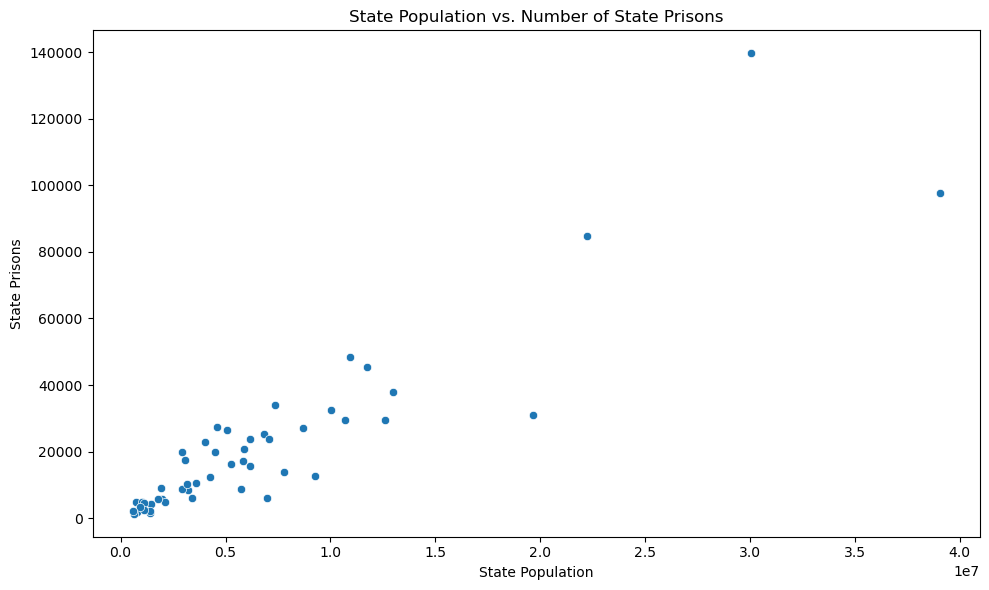

In [70]:
# 1. Scatter plot: State Population vs. Number of State Prisons
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='state_population', y='state_prisons')
plt.title("State Population vs. Number of State Prisons")
plt.xlabel("State Population")
plt.ylabel("State Prisons")
plt.tight_layout()
plt.show()

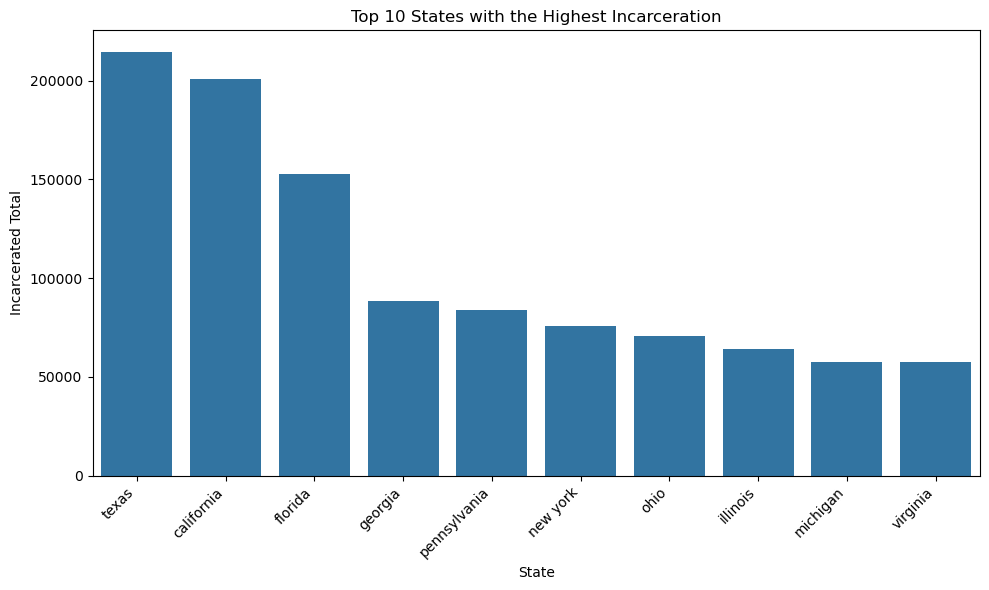

In [71]:
#Visualizations
# 2. Bar chart Top 10 States by Incarcerated Total
top10_incarc = final_df.nlargest(10, 'Incarcerated_Total')
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_incarc, x='state', y='Incarcerated_Total')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 States with the Highest Incarceration")
plt.xlabel("State")
plt.ylabel("Incarcerated Total")
plt.tight_layout()
plt.show()

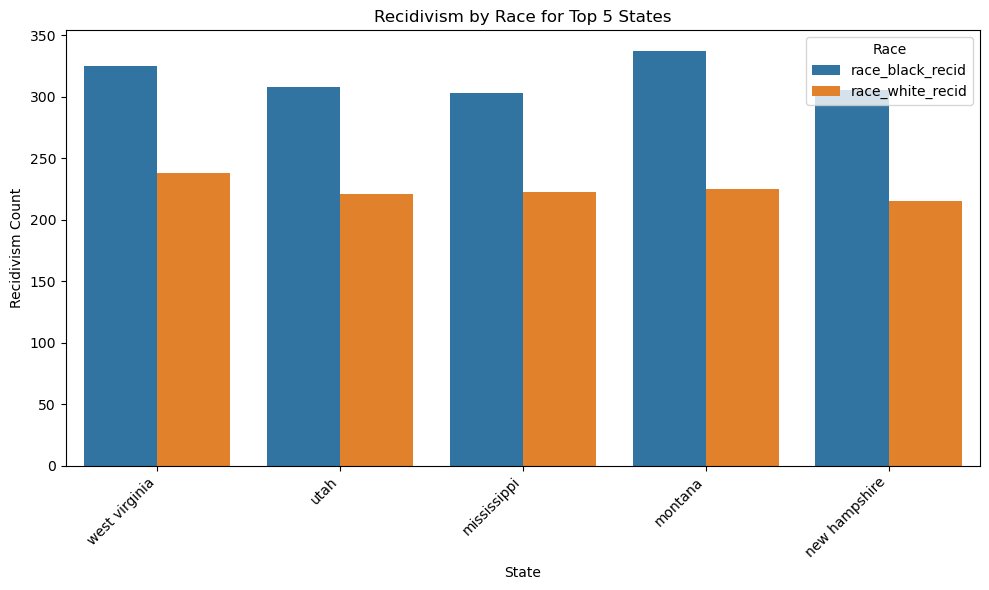

In [72]:
# 3. Grouped bar chart: race recidivism counts for top 5 states by recid_in_3yrs
top5_recid = final_df.nlargest(5, 'recid_in_3yrs').set_index('state')
race_recid = top5_recid[['race_black_recid', 'race_white_recid']].reset_index().melt(id_vars='state')

plt.figure(figsize=(10, 6))
sns.barplot(data=race_recid, x='state', y='value', hue='variable')
plt.xticks(rotation=45, ha='right')
plt.title("Recidivism by Race for Top 5 States")
plt.xlabel("State")
plt.ylabel("Recidivism Count")
plt.legend(title="Race")
plt.tight_layout()
plt.show()

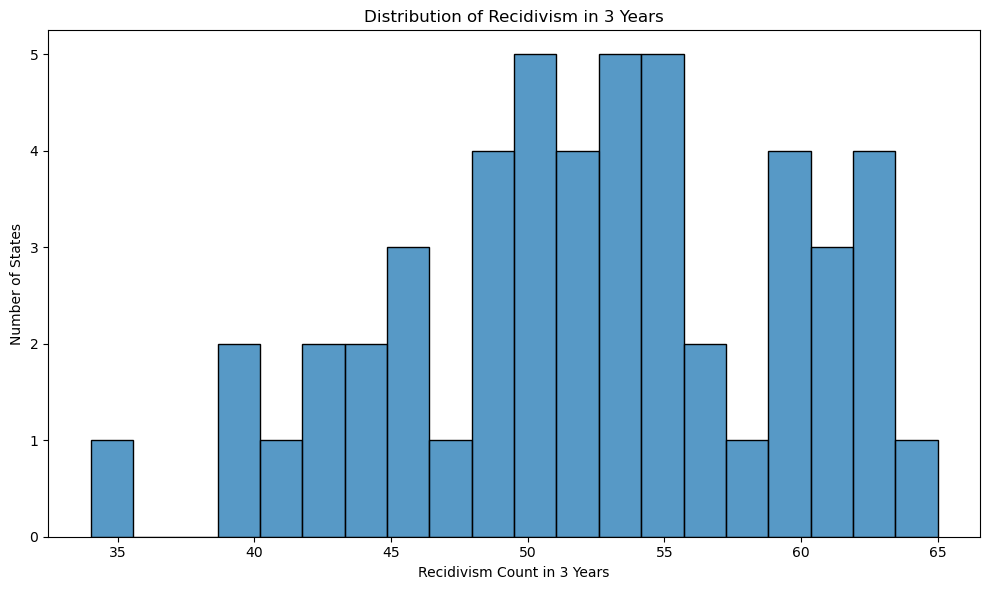

In [73]:
# 4. Histogram of the distribution of recidivism within 3 years across all states
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='recid_in_3yrs', bins=20, kde=False)
plt.title("Distribution of Recidivism in 3 Years")
plt.xlabel("Recidivism Count in 3 Years")
plt.ylabel("Number of States")
plt.tight_layout()
plt.show()

In [74]:
# create a column in the dataframe that shows the net flow --- admissions minus releases
final_df['net_flow'] = final_df['admissions_total']- final_df['releases_total']

In [80]:
# get the count of recidivism race (black/white) by state 
race_cnt = final_df[['state', 'race_black_recid', 'race_white_recid']]

In [76]:
# melt into one row per (state, race, count)
race = race_cnt.melt(
    id_vars='state',
    value_vars=['race_black_recid','race_white_recid'],
    var_name='race',
    value_name='recid_count'
)

In [78]:
# clean up the race labels
race['race'] = race['race'].map({
    'race_black_recid': 'Black',
    'race_white_recid': 'White'
})

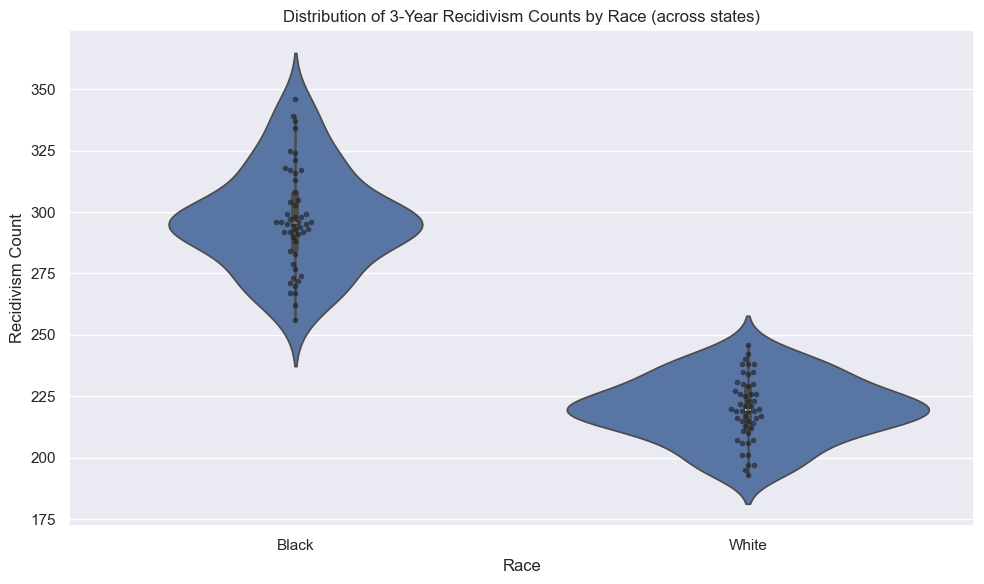

In [79]:
# 5. Violin + swarm plot of net_flow by race
sns.set_theme()
plt.figure(figsize=(10,6))
sns.violinplot(data=race, x='race', y='recid_count')
sns.swarmplot(  data=race, x='race', y='recid_count',
                color='k', size=4, alpha=0.6)
plt.title("Distribution of 3-Year Recidivism Counts by Race (across states)")
plt.xlabel("Race")
plt.ylabel("Recidivism Count")
plt.tight_layout()
plt.show()